In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors,
                           metric = 'haversine',
                           n_jobs = -1)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        vc = data[col].value_counts()
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 14808079
Pos rate: 0.06684128305906525
                        id          match_id     kdist  kneighbors  \
1445478   E_8a16a99b0d0d72  E_fb3e7af3d7e255  0.012287         2.0   
14366305  E_57c0ec16129e0c  E_91056985807574       NaN         NaN   
12287069  E_bdafe498c9d55b  E_06428b47e79f90       NaN         NaN   
5482919   E_a118e8ec97f626  E_24fbd27cbeedaa  0.003003         9.0   
1818783   E_31befa668812ad  E_c697c84def13c6  0.004335         3.0   

         point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
1445478                NaN            NaN                 NaN         NaN   
14366305  P_baf3533ab490dd       0.052602                15.0         NaN   
12287069  P_2e4979db1eb054       0.018630                16.0         NaN   
5482919                NaN            NaN                 NaN         NaN   
1818783   P_3a5fdfcb265b70       0.004335                 3.0         0.0   

          kneighbors_me

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9134185142013433


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,93.32%,6.68%
development set - fold 0,93.32%,6.68%
validation set - fold 0,93.32%,6.68%
development set - fold 1,93.32%,6.68%
validation set - fold 1,93.32%,6.68%
development set - fold 2,93.32%,6.68%
validation set - fold 2,93.32%,6.68%
development set - fold 3,93.32%,6.68%
validation set - fold 3,93.32%,6.68%
development set - fold 4,93.32%,6.68%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

66
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_CE_1', 'cate

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [22]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.038603
[100]	valid_0's binary_logloss: 0.03644
[150]	valid_0's binary_logloss: 0.0351248
[200]	valid_0's binary_logloss: 0.0344824
[250]	valid_0's binary_logloss: 0.0340292
[300]	valid_0's binary_logloss: 0.0335823
[350]	valid_0's binary_logloss: 0.0332195
[400]	valid_0's binary_logloss: 0.0329603
[450]	valid_0's binary_logloss: 0.0326508
[500]	valid_0's binary_logloss: 0.0324016
[550]	valid_0's binary_logloss: 0.0321504
[600]	valid_0's binary_logloss: 0.0319738
[650]	valid_0's binary_logloss: 0.0318387
[700]	valid_0's binary_logloss: 0.0317022
[750]	valid_0's binary_logloss: 0.0315579
[800]	valid_0's binary_logloss: 0.0313704
[850]	valid_0's binary_logloss: 0.031225
[900]	valid_0's binary_logloss: 0.0310971
[950]	valid_0's binary_logloss: 0.0309507
[1000]	valid_0's binary_logloss: 0.0308313
[1050]	valid_0's binary_logloss: 0.0307195
[1100]	valid_0's binary_logloss: 0.0306046
[1150]	valid_0's binary_logloss: 0.0305188
[1200]	valid_0's binary_logloss: 0.

In [23]:
del train_data
gc.collect()

85

#Check Feature Importances

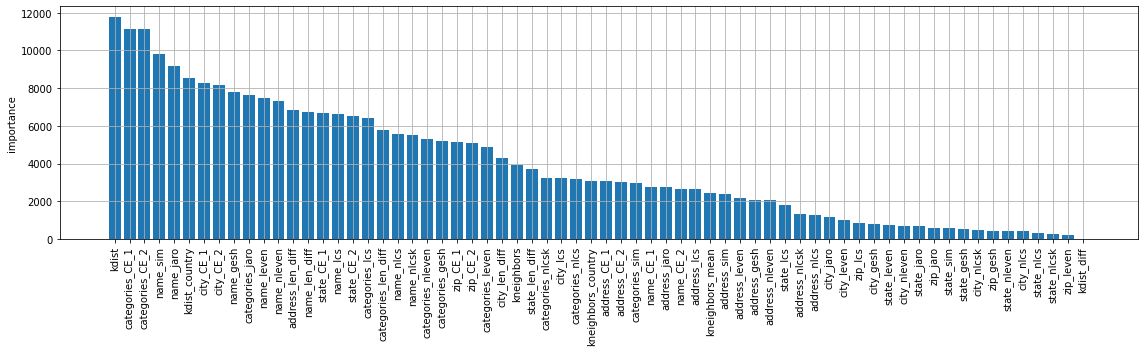

In [24]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-27 18:02:05,754] A new study created in memory with name: no-name-5d7e5dc6-cd3b-45d4-9718-27200f9bcd03
[I 2022-05-27 18:03:00,900] Trial 0 finished with value: 0.811331653515719 and parameters: {'threshold': 0.9134886701223743}. Best is trial 0 with value: 0.811331653515719.


CV: 0.811332


[I 2022-05-27 18:03:23,530] Trial 1 finished with value: 0.7934630183900107 and parameters: {'threshold': 0.1136477249706741}. Best is trial 0 with value: 0.811331653515719.


CV: 0.793463


[I 2022-05-27 18:03:46,453] Trial 2 finished with value: 0.8196153502646785 and parameters: {'threshold': 0.234132190732103}. Best is trial 2 with value: 0.8196153502646785.


CV: 0.819615


[I 2022-05-27 18:04:07,932] Trial 3 finished with value: 0.8250518526144742 and parameters: {'threshold': 0.28521644832625026}. Best is trial 3 with value: 0.8250518526144742.


CV: 0.825052


[I 2022-05-27 18:04:29,113] Trial 4 finished with value: 0.8352656805321805 and parameters: {'threshold': 0.644411177185495}. Best is trial 4 with value: 0.8352656805321805.


CV: 0.835266


[I 2022-05-27 18:04:49,386] Trial 5 finished with value: 0.8359456870275394 and parameters: {'threshold': 0.5802547519801652}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.835946


[I 2022-05-27 18:05:10,947] Trial 6 finished with value: 0.8273226385971266 and parameters: {'threshold': 0.31128158772591974}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.827323


[I 2022-05-27 18:05:31,085] Trial 7 finished with value: 0.761336685000994 and parameters: {'threshold': 0.9861144445582124}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.761337


[I 2022-05-27 18:05:52,850] Trial 8 finished with value: 0.8257495336296509 and parameters: {'threshold': 0.292946849020569}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.825750


[I 2022-05-27 18:06:14,855] Trial 9 finished with value: 0.8224977416248499 and parameters: {'threshold': 0.2592639656936937}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.822498


[I 2022-05-27 18:06:35,507] Trial 10 finished with value: 0.8358136956938323 and parameters: {'threshold': 0.5983482497472492}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.835814


[I 2022-05-27 18:06:57,099] Trial 11 finished with value: 0.8359390860254179 and parameters: {'threshold': 0.5873295090890555}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.835939


[I 2022-05-27 18:07:17,640] Trial 12 finished with value: 0.8290649517107663 and parameters: {'threshold': 0.7882695092692071}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.829065


[I 2022-05-27 18:07:42,892] Trial 13 finished with value: 0.8347124725263025 and parameters: {'threshold': 0.4651025269425676}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.834712


[I 2022-05-27 18:08:04,801] Trial 14 finished with value: 0.8349116747529178 and parameters: {'threshold': 0.4779264774227716}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.834912


[I 2022-05-27 18:08:25,050] Trial 15 finished with value: 0.8305670144282632 and parameters: {'threshold': 0.7667325170348841}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.830567


[I 2022-05-27 18:08:46,740] Trial 16 finished with value: 0.8353427291641069 and parameters: {'threshold': 0.6403325410284455}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.835343


[I 2022-05-27 18:09:08,557] Trial 17 finished with value: 0.8340688503982278 and parameters: {'threshold': 0.4372606061251924}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.834069


[I 2022-05-27 18:09:28,688] Trial 18 finished with value: 0.8285618438270009 and parameters: {'threshold': 0.7941586932248127}. Best is trial 5 with value: 0.8359456870275394.


CV: 0.828562


[I 2022-05-27 18:09:49,912] Trial 19 finished with value: 0.8359535274529333 and parameters: {'threshold': 0.5700261309464559}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835954


[I 2022-05-27 18:10:14,833] Trial 20 finished with value: 0.6850039924493757 and parameters: {'threshold': 0.0169474660002632}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.685004


[I 2022-05-27 18:10:38,871] Trial 21 finished with value: 0.8358938149792465 and parameters: {'threshold': 0.5465152814915665}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835894


[I 2022-05-27 18:11:03,899] Trial 22 finished with value: 0.833917752222678 and parameters: {'threshold': 0.697408151690369}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.833918


[I 2022-05-27 18:11:31,789] Trial 23 finished with value: 0.8337378038411369 and parameters: {'threshold': 0.4287153410047279}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.833738


[I 2022-05-27 18:12:03,242] Trial 24 finished with value: 0.8358411367558896 and parameters: {'threshold': 0.5319366497942514}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835841


[I 2022-05-27 18:12:26,211] Trial 25 finished with value: 0.8316044738699502 and parameters: {'threshold': 0.377086327235041}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.831604


[I 2022-05-27 18:12:49,980] Trial 26 finished with value: 0.8337429333420442 and parameters: {'threshold': 0.700868965856903}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.833743


[I 2022-05-27 18:13:17,679] Trial 27 finished with value: 0.8359456224660244 and parameters: {'threshold': 0.5703164362211128}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835946


[I 2022-05-27 18:13:38,316] Trial 28 finished with value: 0.8169815475723043 and parameters: {'threshold': 0.8888483524466767}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.816982


[I 2022-05-27 18:13:58,999] Trial 29 finished with value: 0.8185754854772573 and parameters: {'threshold': 0.8802406921465942}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.818575


[I 2022-05-27 18:14:20,769] Trial 30 finished with value: 0.8309770287938103 and parameters: {'threshold': 0.36540163745702325}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.830977


[I 2022-05-27 18:14:41,257] Trial 31 finished with value: 0.8359201826601353 and parameters: {'threshold': 0.5638295681666327}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835920


[I 2022-05-27 18:15:02,769] Trial 32 finished with value: 0.8357882524758281 and parameters: {'threshold': 0.6083793953370736}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835788


[I 2022-05-27 18:15:24,327] Trial 33 finished with value: 0.8357085399003221 and parameters: {'threshold': 0.5202517243460094}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835709


[I 2022-05-27 18:15:44,464] Trial 34 finished with value: 0.8337609552824381 and parameters: {'threshold': 0.7002557527613196}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.833761


[I 2022-05-27 18:16:06,680] Trial 35 finished with value: 0.8146036848346293 and parameters: {'threshold': 0.19895183875849798}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.814604


[I 2022-05-27 18:16:27,015] Trial 36 finished with value: 0.835386893772695 and parameters: {'threshold': 0.6369709326798739}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835387


[I 2022-05-27 18:16:48,032] Trial 37 finished with value: 0.8324486468641304 and parameters: {'threshold': 0.7328530542825069}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.832449


[I 2022-05-27 18:17:09,612] Trial 38 finished with value: 0.8359494542607839 and parameters: {'threshold': 0.5786750606204534}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835949


[I 2022-05-27 18:17:31,822] Trial 39 finished with value: 0.8324700516604872 and parameters: {'threshold': 0.39634763533769185}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.832470


[I 2022-05-27 18:17:52,091] Trial 40 finished with value: 0.8250745472299907 and parameters: {'threshold': 0.8320396320311585}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.825075


[I 2022-05-27 18:18:13,568] Trial 41 finished with value: 0.8359179636974932 and parameters: {'threshold': 0.5866486053048555}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835918


[I 2022-05-27 18:18:35,027] Trial 42 finished with value: 0.8353608218551574 and parameters: {'threshold': 0.5006832057088159}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835361


[I 2022-05-27 18:18:55,210] Trial 43 finished with value: 0.8345462848292604 and parameters: {'threshold': 0.6772763390583999}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.834546


[I 2022-05-27 18:19:16,501] Trial 44 finished with value: 0.8359351772731424 and parameters: {'threshold': 0.5883281147957511}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835935


[I 2022-05-27 18:19:37,964] Trial 45 finished with value: 0.8350968004360986 and parameters: {'threshold': 0.48810251136553956}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835097


[I 2022-05-27 18:19:59,314] Trial 46 finished with value: 0.8352865880816698 and parameters: {'threshold': 0.6451754629351543}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835287


[I 2022-05-27 18:20:19,770] Trial 47 finished with value: 0.8358625526424491 and parameters: {'threshold': 0.5525646682766824}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835863


[I 2022-05-27 18:20:41,666] Trial 48 finished with value: 0.8292181103564642 and parameters: {'threshold': 0.3375337467458349}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.829218


[I 2022-05-27 18:21:02,349] Trial 49 finished with value: 0.8343308130953269 and parameters: {'threshold': 0.45185105948168863}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.834331


[I 2022-05-27 18:21:23,419] Trial 50 finished with value: 0.832115792355958 and parameters: {'threshold': 0.7391363580757203}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.832116


[I 2022-05-27 18:21:44,718] Trial 51 finished with value: 0.8357770542905039 and parameters: {'threshold': 0.6034558812966918}. Best is trial 19 with value: 0.8359535274529333.


CV: 0.835777


[I 2022-05-27 18:22:06,105] Trial 52 finished with value: 0.8359884226121734 and parameters: {'threshold': 0.5751635809987619}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.835988


[I 2022-05-27 18:22:26,441] Trial 53 finished with value: 0.835362406853467 and parameters: {'threshold': 0.5010917256411543}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.835362


[I 2022-05-27 18:22:47,739] Trial 54 finished with value: 0.8352776216270454 and parameters: {'threshold': 0.6429001680330195}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.835278


[I 2022-05-27 18:23:08,429] Trial 55 finished with value: 0.8359058599602812 and parameters: {'threshold': 0.5614907335283996}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.835906


[I 2022-05-27 18:23:30,882] Trial 56 finished with value: 0.834749096763229 and parameters: {'threshold': 0.6675808875392478}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.834749


[I 2022-05-27 18:23:55,617] Trial 57 finished with value: 0.8329798522369787 and parameters: {'threshold': 0.40786618369909483}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.832980


[I 2022-05-27 18:24:17,240] Trial 58 finished with value: 0.8347309260306381 and parameters: {'threshold': 0.4670382364592894}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.834731


[I 2022-05-27 18:24:37,588] Trial 59 finished with value: 0.8356757865231433 and parameters: {'threshold': 0.6174437749749255}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.835676


[I 2022-05-27 18:24:59,039] Trial 60 finished with value: 0.8358230576579452 and parameters: {'threshold': 0.529819358999756}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.835823


[I 2022-05-27 18:25:19,739] Trial 61 finished with value: 0.8359389938877482 and parameters: {'threshold': 0.5810025712399081}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.835939


[I 2022-05-27 18:25:41,063] Trial 62 finished with value: 0.83596610142771 and parameters: {'threshold': 0.5768666924458477}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.835966


[I 2022-05-27 18:26:02,613] Trial 63 finished with value: 0.8358093324050224 and parameters: {'threshold': 0.528295321972109}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.835809


[I 2022-05-27 18:26:23,990] Trial 64 finished with value: 0.8345921880031838 and parameters: {'threshold': 0.6749382309657839}. Best is trial 52 with value: 0.8359884226121734.


CV: 0.834592


[I 2022-05-27 18:26:44,672] Trial 65 finished with value: 0.8359886933266473 and parameters: {'threshold': 0.574728935631227}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835989


[I 2022-05-27 18:27:06,394] Trial 66 finished with value: 0.8355788337538298 and parameters: {'threshold': 0.6252546396430727}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835579


[I 2022-05-27 18:27:27,906] Trial 67 finished with value: 0.8322788934210921 and parameters: {'threshold': 0.7355777251697435}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.832279


[I 2022-05-27 18:27:52,397] Trial 68 finished with value: 0.8338148436570353 and parameters: {'threshold': 0.43149309589589546}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.833815


[I 2022-05-27 18:28:14,490] Trial 69 finished with value: 0.835464956804874 and parameters: {'threshold': 0.5071913956432696}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835465


[I 2022-05-27 18:28:35,061] Trial 70 finished with value: 0.835866246750443 and parameters: {'threshold': 0.5569856653324956}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835866


[I 2022-05-27 18:28:56,589] Trial 71 finished with value: 0.8359452966309261 and parameters: {'threshold': 0.5830167646161702}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835945


[I 2022-05-27 18:29:17,382] Trial 72 finished with value: 0.8359355708295392 and parameters: {'threshold': 0.5777280122699265}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835936


[I 2022-05-27 18:29:38,947] Trial 73 finished with value: 0.8349949639164911 and parameters: {'threshold': 0.4809997967376174}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.834995


[I 2022-05-27 18:30:00,463] Trial 74 finished with value: 0.8357054247589024 and parameters: {'threshold': 0.6150493369629301}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835705


[I 2022-05-27 18:30:20,941] Trial 75 finished with value: 0.8348028836633276 and parameters: {'threshold': 0.6659516681411267}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.834803


[I 2022-05-27 18:30:42,726] Trial 76 finished with value: 0.8358694789163903 and parameters: {'threshold': 0.5338358772679859}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835869


[I 2022-05-27 18:31:04,334] Trial 77 finished with value: 0.8336079132299262 and parameters: {'threshold': 0.7050659492235798}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.833608


[I 2022-05-27 18:31:26,201] Trial 78 finished with value: 0.8358176835986159 and parameters: {'threshold': 0.5999302502276839}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835818


[I 2022-05-27 18:31:46,884] Trial 79 finished with value: 0.8358571643151402 and parameters: {'threshold': 0.5530590060903553}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835857


[I 2022-05-27 18:32:09,145] Trial 80 finished with value: 0.835277782171064 and parameters: {'threshold': 0.6437585711846358}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835278


[I 2022-05-27 18:32:29,802] Trial 81 finished with value: 0.8359783463035797 and parameters: {'threshold': 0.5758935644334942}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835978


[I 2022-05-27 18:32:51,524] Trial 82 finished with value: 0.8359549217374155 and parameters: {'threshold': 0.5699682035675926}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835955


[I 2022-05-27 18:33:13,297] Trial 83 finished with value: 0.8356405317288654 and parameters: {'threshold': 0.5141133531011186}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835641


[I 2022-05-27 18:33:34,308] Trial 84 finished with value: 0.8347382904161663 and parameters: {'threshold': 0.4671260037840351}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.834738


[I 2022-05-27 18:33:56,036] Trial 85 finished with value: 0.8358900187619929 and parameters: {'threshold': 0.5393140454352617}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835890


[I 2022-05-27 18:34:17,705] Trial 86 finished with value: 0.8356670261201824 and parameters: {'threshold': 0.6208363859954601}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835667


[I 2022-05-27 18:34:38,279] Trial 87 finished with value: 0.8359358411637192 and parameters: {'threshold': 0.5689516839905144}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835936


[I 2022-05-27 18:34:59,637] Trial 88 finished with value: 0.8350749544688939 and parameters: {'threshold': 0.6548307540706639}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835075


[I 2022-05-27 18:35:21,489] Trial 89 finished with value: 0.8352452322287416 and parameters: {'threshold': 0.49512085170694187}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835245


[I 2022-05-27 18:35:43,085] Trial 90 finished with value: 0.8358177559536945 and parameters: {'threshold': 0.5984097609129966}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835818


[I 2022-05-27 18:36:06,588] Trial 91 finished with value: 0.8359407589915884 and parameters: {'threshold': 0.5806564515934993}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835941


[I 2022-05-27 18:36:28,184] Trial 92 finished with value: 0.8358600790945448 and parameters: {'threshold': 0.552903689493703}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835860


[I 2022-05-27 18:36:53,999] Trial 93 finished with value: 0.6613788319393572 and parameters: {'threshold': 0.012362475239644621}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.661379


[I 2022-05-27 18:37:15,739] Trial 94 finished with value: 0.8354547541281708 and parameters: {'threshold': 0.6327637908761353}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835455


[I 2022-05-27 18:37:37,525] Trial 95 finished with value: 0.8340721666431598 and parameters: {'threshold': 0.6928399851450702}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.834072


[I 2022-05-27 18:37:58,795] Trial 96 finished with value: 0.835699899413203 and parameters: {'threshold': 0.5223635681230376}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835700


[I 2022-05-27 18:38:21,681] Trial 97 finished with value: 0.7984870009094703 and parameters: {'threshold': 0.12805676266827737}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.798487


[I 2022-05-27 18:38:42,754] Trial 98 finished with value: 0.8358117413579611 and parameters: {'threshold': 0.5980417727384849}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.835812


[I 2022-05-27 18:39:05,263] Trial 99 finished with value: 0.8342649642657872 and parameters: {'threshold': 0.448605789859647}. Best is trial 65 with value: 0.8359886933266473.


CV: 0.834265


In [ ]:
threshold = study.best_params['threshold']
threshold

0.574728935631227

In [ ]:
study.best_value

0.8359886933266473

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.835989


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,117800.000000,117800.000000,125316.000000,125316.000000,116085.0,125853.000000,125853.0,125853.000000,125853.000000,125853.000000,...,93158.000000,93158.000000,93158.000000,106359.000000,106597.000000,125853.000000,93158.000000,93158.000000,93158.000000,1.258530e+05
mean,0.001682,6.464975,0.003543,6.368381,0.0,6.580491,1.0,0.263269,0.407179,16.735167,...,12.627772,0.673918,9.160491,5621.569994,5632.965140,9.205375,0.538498,0.580964,0.581350,1.968238e-01
std,0.002523,5.289697,0.023928,5.271790,0.0,5.305120,0.0,0.295753,0.247097,9.455449,...,11.690008,0.242922,7.434006,6792.266828,6795.063543,11.099061,0.352204,0.329773,0.329416,1.796848e-01
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.414334e-09
25%,0.000319,2.000000,0.000342,2.000000,0.0,2.000000,1.0,0.000000,0.208333,10.000000,...,0.000000,0.483660,4.000000,755.000000,755.000000,0.000000,0.000000,0.285714,0.285714,3.001785e-02
50%,0.000794,5.000000,0.000879,5.000000,0.0,5.000000,1.0,0.172145,0.390244,16.000000,...,12.000000,0.583333,7.000000,2905.000000,2905.000000,6.000000,0.714286,0.480000,0.480000,1.438250e-01
75%,0.001953,10.000000,0.002383,10.000000,0.0,10.000000,1.0,0.488826,0.583333,22.000000,...,17.000000,1.000000,12.000000,7208.000000,7208.000000,13.000000,0.823529,1.000000,1.000000,3.449741e-01
max,0.037195,19.000000,2.388985,19.000000,0.0,19.000000,1.0,1.000000,1.000000,59.000000,...,87.000000,1.000000,77.000000,25481.000000,25481.000000,90.000000,1.000000,1.000000,1.000000,5.747228e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
7075703,E_6d03f7b3f399d5,E_8ad98c9f62a761,0.001391,12.0,P_bc771029218154,0.001391,12.0,0.0,12.0,1,...,NaN,NaN,NaN,NaN,3086.0,13,NaN,NaN,NaN,0.001639
10182549,E_e1d0206eb62d92,E_cab60f8ce907e5,0.000817,17.0,P_f82d146eaf21da,0.000817,17.0,0.0,17.0,1,...,16.0,0.555672,5.0,436.0,2042.0,3,0.941176,0.357143,0.294118,0.000042
9925319,E_6e372d6ced4163,E_22a6dbc96b889a,0.000564,17.0,P_5cf7676d071d32,0.000564,17.0,0.0,17.0,1,...,0.0,1.000000,9.0,9676.0,9676.0,0,0.000000,1.000000,1.000000,0.523836
3836812,E_bcb36c33d4ab6a,E_0beeb18be5f9a6,0.000153,6.0,P_7c5f67c96b0d53,0.000153,6.0,0.0,6.0,1,...,NaN,NaN,NaN,NaN,11981.0,6,NaN,NaN,NaN,0.257090
8200086,E_66852fb62f5c6e,E_44f98f587f06fb,0.001067,14.0,P_5271fd5f8c141e,0.001067,14.0,0.0,14.0,1,...,16.0,0.681624,11.0,4964.0,21438.0,8,0.615385,0.611111,0.423077,0.037551
2618815,E_991f965c324dcc,E_27aab8512b0011,0.000333,4.0,P_3a186b42adb34e,0.000333,4.0,0.0,4.0,1,...,7.0,0.748538,14.0,2450.0,5376.0,0,0.368421,0.736842,0.736842,0.150628
4581183,E_0b9e1bf2e315e6,E_9d12106ffb6850,0.003292,8.0,P_5f6a9c9c33d3d0,0.003292,8.0,0.0,8.0,1,...,13.0,0.404762,2.0,11385.0,3088.0,7,0.928571,0.285714,0.142857,0.343311
13012211,E_d9e172388f065b,E_afac043d990a98,NaN,NaN,P_863215ef9690da,0.007550,6.0,NaN,6.0,1,...,0.0,1.000000,23.0,3489.0,3489.0,0,0.000000,1.000000,1.000000,0.003873
1072308,E_e1ea02294e721e,E_43de631e570c05,0.000048,1.0,P_9ba038f8753408,0.000048,1.0,0.0,1.0,1,...,5.0,0.774621,11.0,9423.0,3454.0,5,0.312500,0.687500,1.000000,0.192913
1765158,E_1980c775d3e290,E_2a7b9857b4cbcd,0.000955,3.0,P_d49424f9813540,0.000955,3.0,0.0,3.0,1,...,17.0,0.485185,6.0,4407.0,146.0,0,0.850000,0.300000,0.300000,0.464007


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
57479,E_0cddb312c98ba6,ВТБ24,54.309234,48.410108,NaN,NaN,NaN,NaN,RU,NaN,NaN,Banks,P_8ba6da56229fb0,2,1.0
510176,E_72b1a2186d0d13,ВТБ,54.310535,48.398618,NaN,Ульяновск,NaN,NaN,RU,NaN,NaN,Banks,P_8ba6da56229fb0,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
383960,E_564471f27b3830,"Suken A. Shah, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/1297...,+18004164441,Doctor's Offices,P_ce9291000a8f0b,4,1.0
728387,E_a39eae8fb7027b,"Puneeta Ramachandra, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/1425...,+18004164441,Doctor's Offices,P_ce9291000a8f0b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
438985,E_62a8a91bb160ac,Dad-ima Lab,40.818741,-73.597602,NaN,Brookville,NY,NaN,US,NaN,NaN,NaN,P_e9df500ff38b40,1,1.0
768412,E_ac990ad1e5e255,Humanities Hall,40.819510,-73.597003,720 Northern Blvd,Greenvale,NY,11548,US,NaN,5162992000,College Academic Buildings,P_e9df500ff38b40,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
410008,E_5c25c62dfd9885,Seyhanlar Cali,40.173088,28.922424,NaN,NaN,NaN,NaN,TR,NaN,NaN,Convenience Stores,P_a9039f66a5e1da,2,1.0
449903,E_65181f5d084c67,Seyhan Ekpres,40.170442,28.921962,Cali,Bursa,NaN,NaN,TR,NaN,NaN,Grocery Stores,P_a9039f66a5e1da,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
155297,E_22c8e52722c8b4,парк 50-летия Октября (Полюстрово).,59.960453,30.430332,NaN,NaN,NaN,NaN,RU,NaN,NaN,Parks,P_cced0ddd3d427a,4,1.0
706853,E_9ec3632d70b79a,Парк Пятидесятилетия Победы,59.965892,30.427799,NaN,NaN,NaN,NaN,RU,NaN,NaN,Parks,P_cced0ddd3d427a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
63740,E_0e4408b2b0fcc2,Tesco Lotus # ปิ่นเกล้า,13.776672,100.47852,NaN,NaN,NaN,NaN,TH,NaN,NaN,Big Box Stores,P_080e0eb124afc7,4,1.0
494462,E_6f269d0231fae7,Tesco Lotus # Pinklao,13.776792,100.47826,NaN,NaN,NaN,NaN,TH,NaN,NaN,Department Stores,P_080e0eb124afc7,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
229848,E_339660e2b79505,Jumeirah Beach Hotel❤😍😊,25.141724,55.190484,NaN,NaN,NaN,NaN,AE,NaN,NaN,Buildings,P_bb3e45408f34f9,4,1.0
836680,E_bbe499e8d27bee,Room 1305,25.141650,55.190468,Jumeirah Beach Hotel,Dubai,NaN,NaN,AE,NaN,NaN,Residential Buildings (Apartments / Condos),P_bb3e45408f34f9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
403277,E_5a9d99fd37e9a0,The Real Food Co,29.985382,-95.338551,Terminal C,Houston,TX,77032,US,NaN,2812303100,"Cafeterias, Food Courts, Delis / Bodegas",P_21938a79ed56ea,1,1.0
816063,E_b7443588cae436,Texas BBQ,29.985388,-95.339069,NaN,Houston,TX,77032,US,NaN,NaN,BBQ Joints,P_21938a79ed56ea,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
276067,E_3df85b4877fbc2,Departure Platform At Jb Castam,1.464381,103.766303,Jb castam,NaN,NaN,NaN,MY,NaN,NaN,NaN,P_a7829bfa2c8bc6,4,1.0
957369,E_d7107e557b1ad4,Malaysia Immigration Complex,1.465290,103.767118,NaN,NaN,NaN,NaN,MY,NaN,NaN,Government Buildings,P_a7829bfa2c8bc6,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
122337,E_1b6f5ea285ea90,"BS 3, CTF4",1.464031,110.430855,NaN,NaN,NaN,NaN,MY,NaN,NaN,"College Academic Buildings, College Auditoriums",P_5dd9b72f070ec2,2,1.0
287254,E_407e787153985d,"BS 3, CTF 4",1.465076,110.432240,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Academic Buildings,P_5dd9b72f070ec2,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
686991,E_9a4a882f16e268,"Кабинет русского, 8 гг",64.569310,39.841515,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_86afa420d32d95,4,1.0
1073503,E_f142949f372a67,4️⃣этаж 8️⃣гг📚,64.570354,39.839720,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Quads,P_86afa420d32d95,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
516479,E_741624dc290464,Ruang C303,-7.338989,112.736368,"Gedung C Universitas Kristen Petra, Lt. 3",Surabaya,East Java,60236,ID,NaN,NaN,College Classrooms,P_3179b382980447,1,1.0
766103,E_ac14819f202190,Gedung C 303 (Universitas Kristen Petra),-7.338784,112.736374,NaN,Surabaya,East Java,NaN,ID,NaN,NaN,NaN,P_3179b382980447,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
373636,E_53f598ae780158,Ptt Gas Station,16.825312,100.256943,NaN,Nai Muang,Phitsanulok,65000,TH,NaN,NaN,Gas Stations,P_721a779a8058cb,1,1.0
852679,E_bf7e0d9fca1c0d,ปตท. (PTT),16.824871,100.257277,Singhawat Rd,Mueang Phitsanulok,Phitsanulok,65000,TH,NaN,NaN,Gas Stations,P_721a779a8058cb,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
52474,E_0bc0d7fb93a768,ร้านแหนมเนืองหนองคาย,12.729733,101.713997,NaN,NaN,NaN,NaN,TH,NaN,NaN,Vietnamese Restaurants,P_91a59c9461596f,1,1.0
761965,E_ab2b3c6b1ce5c4,หนองคาย แหนมเนือง,12.719992,101.714824,NaN,Klaeng,Rayong,NaN,TH,NaN,NaN,Vietnamese Restaurants,P_91a59c9461596f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
251751,E_38881d57264127,Євразія / Eurasia,50.429422,30.515878,"вул. Велика Васильківська, 88",Київ,м. Київ,NaN,UA,http://evrasia.in.ua,442871360,"Sushi Restaurants, Japanese Restaurants",P_82fed3812292cf,1,1.0
958196,E_d740acd35999a6,Евразия,50.426548,30.515788,Велика Васильківська 88,Київ,NaN,NaN,UA,NaN,NaN,Sushi Restaurants,P_82fed3812292cf,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
427931,E_6027f93247d179,RSUD tasik,-7.331900,108.225059,Jl rumah sakit,Tasik,Jawa Barat,NaN,ID,NaN,NaN,NaN,P_983732d41744ca,4,1.0
479911,E_6bd96773fa3948,Rumah Sakit Umum,-7.331969,108.224537,NaN,Tasikmalaya,West Java,NaN,ID,NaN,NaN,Hospitals,P_983732d41744ca,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
78443,E_118946ee7fecbf,Camlica Park,41.021994,29.064246,Kisikli meydani,Istanbul,NaN,NaN,TR,NaN,NaN,Scenic Lookouts,P_8c4dd5535feb66,4,1.0
231275,E_33e9795293e863,Çamlıca Tepesi,41.022301,29.070405,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Great Outdoors,P_8c4dd5535feb66,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
131652,E_1d831f8b8d8283,USM Hockey Turf,5.354218,100.294329,Universiti Sains Malaysia (USM),USM,Penang,11800,MY,NaN,NaN,College Hockey Rinks,P_d2ce269612271b,2,1.0
559565,E_7dc4149954a174,stadium hoki,5.355201,100.295901,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Hockey Rinks,P_d2ce269612271b,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
178711,E_2817fd77cea5a5,Özdilek Cafe & Restaurant,40.266881,28.949122,NaN,NaN,NaN,NaN,TR,NaN,NaN,Restaurants,P_cdd191cb7a0338,1,1.0
758584,E_aa6a508b2b99de,Kafe Safahat,40.267472,28.949115,Özdilek Bursa Geçit AVM,Osmangazi,NaN,16150,TR,http://www.kafesafahat.com,+904444416,"Cafés, Breakfast Spots",P_cdd191cb7a0338,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
81073,E_122114a2593319,WorkHouse,55.714571,37.515681,Щербакова 1а,Мытищи,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_a8cb2a44ab9a3c,4,1.0
700287,E_9d4962c452b73e,44 Кабинет,55.714255,37.514327,Школа 1214,NaN,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_a8cb2a44ab9a3c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
107626,E_18209dccc85cf6,FCPyS D-312,19.318808,-99.177086,NaN,NaN,NaN,NaN,MX,NaN,NaN,College Classrooms,P_9349e307b2b687,1,1.0
576073,E_817f942b323238,D-301 FCPyS,19.318746,-99.176996,Ciudad Universitaria,NaN,NaN,NaN,MX,NaN,NaN,College Classrooms,P_9349e307b2b687,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
985654,E_dd6e3cef0caf87,Türk Pirelli Lastikleri,40.755949,29.998100,Ankara Cad. No:269,"İzmit, Kocaeli",Türkiye,41188,TR,http://www.pirelli.com,2623152000,Factories,P_f6882124f84a36,4,1.0
1136563,E_ff7dd692a6cdce,pirelli bobin ıskarta alanı,40.756105,29.998638,NaN,NaN,NaN,NaN,TR,NaN,NaN,Arcades,P_f6882124f84a36,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
979081,E_dbf0cd3233b05e,Kyk Erkek Yurdu Ders Çalışma odasi,40.649544,35.795086,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_37472858a716a3,4,1.0
1006018,E_e1fbbab21c2eb0,Kyk A 209,40.648621,35.795487,NaN,NaN,NaN,NaN,TR,NaN,NaN,Community Centers,P_37472858a716a3,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
53709,E_0c06ef82d7d66e,K-Bank Wanghin Senanikom,13.823949,100.591433,NaN,Lat Phrao,Bangkok,NaN,TH,NaN,NaN,NaN,P_ba32b35d86135f,3,1.0
323927,E_48d351906fadaa,ธนาคารกสิกรไทย (KASIKORNBANK),13.823882,100.591339,Tesco Lotus Wanghin,Lad Phrao,Bangkok,10230,TH,http://www.kasikornbank.com,025786341,Banks,P_ba32b35d86135f,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
264145,E_3b5220b38c11eb,ŠKODA Auto AC PMK 7th floor,50.424428,14.917342,Tř. Václava Klementa 699,Mladá Boleslav,NaN,293 01,CZ,NaN,NaN,NaN,P_e44bf6af29b8b9,3,1.0
291087,E_415eeef374cace,skoda auto ac 7th floor VME,50.424528,14.917086,Tr.vaclava Klemeneta 699,Mladá Boleslav,Středočeský,293 01,CZ,NaN,NaN,NaN,P_e44bf6af29b8b9,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
879202,E_c57ada921dbf33,Kadınlar Plajı,42.019149,35.163879,Karakum Yolu 1. Km,Sinop,NaN,NaN,TR,NaN,NaN,Beaches,P_e2b0c95e137f2d,1,1.0
923012,E_cf57396b26d9db,Sinop Amozona Plajı,42.019065,35.164057,Sinop,Sinop,sinop,NaN,TR,NaN,NaN,Water Parks,P_e2b0c95e137f2d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
108985,E_186da80972a664,Merku's Bar,-25.569162,-52.049713,Av. Anísio Pedro da Luz,Candói,Paraná,85140-000,BR,NaN,NaN,Bars,P_5c9dccbfaae20e,1,1.0
936828,E_d26f71363f2d20,Lanchonete Merku's,-25.568611,-52.050500,NaN,NaN,NaN,NaN,BR,NaN,NaN,Breweries,P_5c9dccbfaae20e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
496539,E_6f9bf8b34781b6,"""ТСК \""Гала\""""",60.026964,30.288236,Щербакова 18,NaN,NaN,NaN,RU,NaN,NaN,"Dance Studios, Country Dance Clubs, Event Spaces",P_d65bbbfecccb13,1,1.0
755685,E_a9c221228604b0,Дворец молодежи,60.026637,30.287954,NaN,NaN,NaN,NaN,RU,NaN,NaN,Event Spaces,P_d65bbbfecccb13,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1007912,E_e2652c3afc9318,Praia de Pipa,-6.227654,-35.048885,NaN,NaN,NaN,NaN,BR,NaN,NaN,Beaches,P_6142326eb038a0,3,1.0
1071797,E_f0e033d8d615b3,Pipa,-6.232880,-35.044415,NaN,NaN,Rio Grande do Norte,59178-000,BR,NaN,NaN,General Travel,P_6142326eb038a0,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
625554,E_8ca68d53dcc766,BANK BNI,-6.110142,106.879812,JL.SAMPING STASIUN NO.1,JAKARTA UTARA,NaN,NaN,ID,NaN,NaN,Banks,P_920816063ddd16,3,1.0
1122696,E_fc61ef9633ff07,BNI Tg. Priok,-6.111024,106.882440,Terminal Tg. Priok,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_920816063ddd16,3,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,42924.000000,42924.000000,45509.000000,45509.000000,42417.0,45541.000000,45541.0,45541.000000,45530.000000,45530.000000,...,37401.000000,37401.000000,37401.000000,40858.000000,40786.000000,45541.000000,37401.000000,37401.000000,37401.000000,45541.000000
mean,0.001511,4.479895,0.002738,4.385155,0.0,4.598263,0.0,0.504460,0.589986,12.664968,...,10.206037,0.777973,11.163525,5382.376181,5375.106237,8.733800,0.386808,0.727241,0.727111,0.799625
std,0.002506,4.726831,0.010152,4.691107,0.0,4.776858,0.0,0.343204,0.263177,9.582728,...,12.115287,0.239775,7.751677,6503.257532,6484.386966,11.585869,0.364134,0.325613,0.325432,0.131189
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.574732
25%,0.000210,1.000000,0.000224,1.000000,0.0,1.000000,0.0,0.213802,0.413793,5.000000,...,0.000000,0.534392,5.000000,605.000000,605.000000,0.000000,0.000000,0.405405,0.409091,0.682317
50%,0.000557,2.000000,0.000631,2.000000,0.0,2.000000,0.0,0.548170,0.615385,11.000000,...,8.000000,0.876667,10.000000,2872.000000,2872.000000,4.000000,0.440000,1.000000,1.000000,0.803079
75%,0.001630,6.000000,0.002036,6.000000,0.0,6.500000,0.0,0.781064,0.789474,18.000000,...,16.000000,1.000000,15.000000,7208.000000,7208.000000,14.000000,0.750000,1.000000,1.000000,0.921273
max,0.038398,19.000000,0.640223,19.000000,0.0,19.000000,0.0,1.000000,1.000000,57.000000,...,82.000000,1.000000,93.000000,25481.000000,25481.000000,83.000000,1.000000,1.000000,1.000000,0.999998


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
1695948,E_fa76d5ac05a8cf,E_952f657623e54d,0.000099,2.0,P_fbb225da3493de,0.000099,2.0,0.0,2.0,0,...,0.0,1.000000,15.0,4722.0,4722.0,0,0.000000,1.000000,1.000000,0.936452
13758083,E_1af2b6a136d6ac,E_232c48e2750c4b,NaN,NaN,P_a501e0f55f2032,0.008993,17.0,NaN,17.0,0,...,9.0,0.857353,8.0,1931.0,2920.0,9,0.529412,1.000000,0.470588,0.762169
9909988,E_67415c92feff32,E_abf9061916bf90,0.001996,17.0,P_34086a52523805,0.001996,17.0,0.0,17.0,0,...,NaN,NaN,NaN,21438.0,NaN,15,NaN,NaN,NaN,0.724384
1151788,E_05ce8bcda9e2dd,E_3df7ffbdd46026,0.000949,2.0,P_5490c1e0e4d99f,0.000949,2.0,0.0,2.0,0,...,0.0,1.000000,9.0,316.0,316.0,0,0.000000,1.000000,1.000000,0.611789
627965,E_1a3eb3ccc01ae9,E_6eca67dbd4b79a,0.000017,1.0,P_469317e2c4dc59,0.000017,1.0,0.0,1.0,0,...,27.0,0.479798,7.0,1073.0,3.0,15,0.818182,0.212121,0.388889,0.767379
11995563,E_0a9710bafb24f3,E_97cd3d973c56a6,NaN,NaN,P_87f1645cf83531,0.017027,16.0,NaN,16.0,0,...,NaN,NaN,NaN,2663.0,NaN,2,NaN,NaN,NaN,0.909955
12381294,E_962e24d6226ab3,E_c11b1f9df83664,NaN,NaN,P_7592b1619e4b8e,0.006704,18.0,NaN,18.0,0,...,0.0,1.000000,24.0,258.0,258.0,0,0.000000,1.000000,1.000000,0.990177
717419,E_426e98b8d6d462,E_7853023aa107d7,0.000232,1.0,P_38dcee2b8817e0,0.000232,1.0,0.0,1.0,0,...,NaN,NaN,NaN,17097.0,NaN,9,NaN,NaN,NaN,0.813751
3955970,E_f271585302effc,E_483b4584132908,0.001156,6.0,P_4c0949f54859f2,0.001156,6.0,0.0,6.0,0,...,NaN,NaN,NaN,5956.0,NaN,11,NaN,NaN,NaN,0.748869
10840637,E_09d99f455cb511,E_b285e030b1bae8,0.000061,19.0,P_1985240101daca,0.000061,19.0,0.0,19.0,0,...,10.0,0.405556,2.0,318.0,385.0,2,0.833333,0.166667,0.200000,0.775369


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
104841,E_1780f2357170aa,Aeropuerto Internacional de Cancun,21.041248,-86.87130,NaN,Cancun,"Quintanarro, Mexico",NaN,MX,NaN,NaN,Airports,P_d52a827965cb97,4,1.0
522976,E_7586400bee05cc,Aeropuerto Internacional De Cancún,21.039420,-86.87359,NaN,Cancún,Quintana Roo,NaN,MX,NaN,NaN,Airport Services,P_9ca69dcf5ec974,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
38665,E_08acdfd9f689a7,Ward 7B Hospital Selayang,3.243479,101.646276,NaN,NaN,NaN,NaN,MY,NaN,NaN,Hospitals,P_20251253b92278,0,1.0
73486,E_1074b321244e35,Hospital Selayang,3.242717,101.647387,NaN,NaN,NaN,NaN,MY,NaN,NaN,Hospitals,P_48e9fcbace22dc,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
656531,E_93899239806957,Procraft Renovations,40.824624,-96.692026,6205 N 34th St,Lincoln,NE,68504,US,NaN,+14024031087,Home Services & Repairs,P_a570cb06402034,1,1.0
750648,E_a8a20800af4423,NaN,40.822332,-96.689102,NaN,NaN,AK,NaN,US,NaN,NaN,NaN,P_be5d12315d8588,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
664630,E_95554d7f4e2f68,Tantawan Plaza,13.855219,100.543359,NaN,NaN,NaN,NaN,TH,NaN,NaN,Plazas,P_1b7cc82500c2b8,0,1.0
1090484,E_f50fe42a6affa0,ร้านเสน่ห์สาว,13.855219,100.543106,ซอยเดลี่พล่าซ่า,NaN,NaN,NaN,TH,NaN,NaN,"Spas, Cosmetics Shops",P_e4e199eecf0c70,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
77224,E_1145ea53337999,Battalbey Çiğ Köftecisi,38.472388,27.086071,Yalı Mah. 6431 Sok. No:1/B Atakent Karşıyaka,İzmir,İzmir,35550,TR,NaN,+902323623236,"Turkish Restaurants, Snack Places",P_a556bc5a0a15de,1,1.0
210322,E_2f368319d96fae,Temiz Mandıra Kahvaltı Brunch,38.472548,27.086129,NaN,NaN,NaN,NaN,TR,NaN,NaN,Turkish Restaurants,P_e9bd6ccceb8cf4,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
148153,E_213849e1d62ada,Ankara 33. Asliye Ceza Mahkemesi,39.928777,32.853275,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_f58871cd625807,4,1.0
941747,E_d3877f09320125,Ankara Adliyesi İdari İşler Müdürlüğü,39.929146,32.853512,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_e00b9832620943,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
442661,E_637b147228551c,Cash Crusaders,-29.913213,30.882165,17 Joyhurst Street,Durban,KwaZulu-Natal,4029,ZA,http://www.cashcrusaders.co.za,+27314021923,NaN,P_a6c5d8c1504897,0,1.0
973985,E_dac98163d79884,Chatsworth Centre,-29.913117,30.879076,17 Joyhurst St,Chatsworth,NaN,4092,ZA,NaN,314035451,Shopping Malls,P_71e005aacbe9f7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
398128,E_59763ba716b7bd,Tepe Prime Avenue,39.909270,32.755159,Mustafa Kemal Mah. Dumlupınar Bulvarı No:266,Çankaya,Ankara,06530,TR,http://www.tepeprime.com.tr,3122876146,Shopping Malls,P_44cb8d6b8a8982,1,1.0
436065,E_6200c816b40321,TEPE PRIME -B-,39.908588,32.754708,NaN,NaN,NaN,NaN,TR,NaN,NaN,Beaches,P_bf16550e26de1f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
929496,E_d0ccbb47f20e1b,Gate 31,40.756795,-73.991218,NaN,New York,NY,10036,US,NaN,NaN,Bus Stations,P_fc7960b13b7fea,0,1.0
1116486,E_fb00d1a8d60684,Gate 301,40.757105,-73.990576,North Terminal,New York,NY,10018,US,NaN,NaN,Bus Stations,P_45f25dca9f21fa,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
24436,E_057bfb1dd6b605,Perron 7,51.023144,4.099968,NaN,Dendermonde,Oost-Vlaanderen,9200,BE,NaN,NaN,Bus Stops,P_d1f5749654224d,0,1.0
1023342,E_e5f0d8a7408747,Perron 5,51.023247,4.100073,Halte station,Dendermonde,Oost-Vlaanderen,9200,BE,NaN,NaN,"Bus Stops, Bus Stations",P_0183934f6e95b1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
959265,E_d77bc6ba45a72d,The Carmel Hat Company,36.554699,-121.922008,NaN,Carmel-by-the-Sea,CA,NaN,US,NaN,NaN,Arts & Crafts Stores,P_ccac1e1098a719,1,1.0
1063354,E_eefc3aa2a4e749,The Carmel Coffee House and Roasting Company,36.554765,-121.922341,Ocean Ave,Carmel,CA,93921,US,NaN,8316262095,Coffee Shops,P_5524b9931e2944,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
302313,E_43e133aac81129,UMM Dome,-7.920873,112.596833,NaN,Malang,East Java,NaN,ID,NaN,NaN,NaN,P_87a53941048b8b,4,1.0
468861,E_695d815e2d1022,UMM Inn Hotel Pendidikan,-7.920782,112.593946,NaN,Kabupaten Malang,NaN,NaN,ID,NaN,NaN,"Bed & Breakfasts, Hotels, College Math Buildings",P_e57b5c439d5ffc,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
652869,E_92b53b686e2348,Kitnet,-22.821306,-47.079199,Rua Francisco Humberto Zuppi,Campinas,Sao Paulo,13083-350,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_3d3f59ea1e8c00,0,1.0
996595,E_dfe13ed128c2c3,Kitnete 5,-22.821930,-47.079750,NaN,NaN,NaN,NaN,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_3d04a80a7be393,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
584662,E_836c4487701fb2,The Golden Wheel Hotel,50.088863,14.398746,Nerudova 217/28,Prag,Prag,118 00,CZ,http://www.thegoldenwheel.com,+420257535490,Hotels,P_193598378d2115,2,1.0
1040040,E_e9ab8dee1af9d5,Breakfast @ Golden Key Hotel,50.088487,14.399045,NaN,NaN,NaN,NaN,CZ,NaN,NaN,Hotels,P_cda5a03ae56cb5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
306125,E_44becfb5deb11a,Signature Old Town White Coffee,4.588302,101.077621,jalan leong bun sui,Ipoh,Perak,NaN,MY,NaN,NaN,"Cafés, Coffee Shops, Malay Restaurants",P_5cb071683e19fe,0,1.0
428904,E_6062598662f31e,"Old town White Coffee, Ampang",4.587326,101.116420,NaN,NaN,NaN,NaN,MY,NaN,NaN,Coffee Shops,P_f6412d3037ecac,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
154541,E_229f7c0b03cc42,West Virginia State University,38.371511,-81.747912,NaN,Dunbar,WV,25064,US,NaN,NaN,General Colleges & Universities,P_bfbe1e338f9d1f,0,1.0
402741,E_5a7e3923095f6d,West Virginia State University,38.380965,-81.766010,5000 Fairlawn Ave,Dunbar,WV,25064,US,NaN,3047663000,Universities,P_3c062ece5dbc4c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
156178,E_22fd276fabbe0b,الهيئة العامة للصناعة,29.270894,48.017700,NaN,NaN,NaN,NaN,KW,NaN,NaN,Government Buildings,P_5e601d6addfc40,1,1.0
732951,E_a4a2c3b89fc5f6,الهيئة العامة للمعلومات المدنية,29.268463,48.014114,Ministries Area,Al Zahra,Hawalli Governorate,NaN,KW,NaN,+9651889988,"Government Buildings, Tech Startups, Conferenc...",P_29482ec5170092,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
51260,E_0b7999ee2e185a,Los Angeles,34.052235,-118.243680,NaN,Los Angeles,Calif,NaN,US,NaN,NaN,Beach Bars,P_639a202f406558,0,1.0
321676,E_48515bf8948b80,Los Angeles Personal Injury Attorney,34.052489,-118.244466,3460 Wilshire Blvd #410G,Los Angeles,CA,90010,US,NaN,+14242312013,Financial or Legal Services,P_746d7e3d73829b,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
543633,E_7a2ae59a6b1f15,Meijer Bottle Return,42.026544,-86.515867,NaN,Stevensville,MI,49127,US,NaN,NaN,Recycling Facilities,P_9ce4409f1a8764,0,1.0
837020,E_bbf7ba9508571c,Meijer,42.026483,-86.515980,5019 Red Arrow Hwy,Stevensville,MI,49127,US,http://www.meijer.com,+12695562400,"Supermarkets, Grocery Stores",P_f2ab6a4f1e4634,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
263944,E_3b467b724d762a,Sunway College Johor Bahru,1.559294,103.779963,3 Jalan Austin Heights Utama,Johor Bahru,Johor,81100,MY,http://sunway.edu.my/jb,73596880,"General Colleges & Universities, Colleges & Un...",P_711081800b3666,0,1.0
554024,E_7c86d91391076d,Room 313 @ Sunway College,1.559320,103.779561,NaN,Johor Bahru,Johor,NaN,MY,NaN,NaN,College Rec Centers,P_5ffe7e6684b977,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
10271,E_025637f020e9f7,The One Academy - A1,3.073234,101.610085,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Classrooms,P_f805d70ed5d9f8,0,1.0
788011,E_b10217c05602f7,The One Academy - A2,3.073269,101.610048,Kolej The One Academy 28 Jalan PJS 11/28A,Petaling Jaya,Selangor,46150,MY,NaN,NaN,College Classrooms,P_480f31262b25bb,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
191382,E_2af16b7986cd63,Queenscliff-Sorrento Ferry,-38.265512,144.672775,Wharf St.,Queenscliff,VIC,NaN,AU,NaN,NaN,Boats or Ferries,P_af56aa20430dd2,1,1.0
571347,E_806f85f6c68e45,Queenscliff Pier,-38.268329,144.668525,NaN,NaN,NaN,NaN,AU,NaN,NaN,Piers,P_ea5479ca2733a1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
377150,E_54bc93f5d75c56,Wisma Nusantara 30 Bawah (Bali Bawah),-6.929439,107.763312,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_043eb850e77175,1,1.0
655322,E_93448a18a66a2d,Barak Sulteng Bawah,-6.929349,107.763028,Kampus IPDN Jatinangor,"Jatinangor, Bandung","Jawa Barat, Indonesia",NaN,ID,NaN,NaN,Tracks,P_6bd01ae3dddbf7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
340276,E_4c7d0e3285e9d2,Özel Damla Kız Öğrenci Yurdu,40.912047,38.377448,İnnönü Caddesi Hacı Siyam Mahallesi,Giresun,NaN,NaN,TR,NaN,NaN,Sorority Houses,P_ff5e6b05e7eff2,0,1.0
1132671,E_fe9abaf358315d,Özel Bahar Kız Öğrenci Yurdu,40.911947,38.377662,NaN,Giresun,NaN,NaN,TR,NaN,NaN,Housing Developments,P_a5ecd9c8eada19,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
281270,E_3f21a4d4f6c7a1,CATS-#22 BAY C,35.224775,-80.840830,115 S Brevard St,Charlotte,NC,28202,US,NaN,NaN,Bus Stations,P_40024901d1e2ba,0,1.0
1094876,E_f614bab5f3c727,CATS - BAY S #15,35.222072,-80.835446,NaN,NaN,NaN,NaN,US,NaN,NaN,Bus Stations,P_5acc9729452a8c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
462927,E_6800ac87e878f2,重慶抄手麵食,25.080217,121.590943,成功路三段187巷1號,內湖區,台北市,NaN,TW,NaN,0227904355,Noodle Houses,P_9686449dd94e0d,0,1.0
744526,E_a7447847c187fd,釆岳軒重慶抄手麵食,25.079629,121.590659,NaN,NaN,NaN,NaN,TW,NaN,NaN,Asian Restaurants,P_b7c6a26f63cbf6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
415147,E_5d4370a8b06f86,반석마을4단지,36.391119,127.310023,유성구 반석동,대전시,NaN,NaN,KR,NaN,NaN,Residential Buildings (Apartments / Condos),P_7caa3cf4e18cc6,0,1.0
416334,E_5d87f09380e30f,반석마을5단지,36.390828,127.311600,NaN,NaN,NaN,NaN,KR,NaN,NaN,Residential Buildings (Apartments / Condos),P_7121a0907bb186,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
128365,E_1cc7c2f731ed1d,Kurtz Dog,-30.031325,-51.227184,NaN,NaN,NaN,NaN,BR,NaN,+555130133693,Hot Dog Joints,P_1766c27372905a,1,1.0
130066,E_1d29225d9f209e,Super Dog,-30.031424,-51.224174,"Av. João Pessoa, 5-9 - Centro",Porto Alegre,Rio Grande do Sul,90040-000,BR,NaN,NaN,"Food Trucks, Hot Dog Joints",P_bd672512e8a43e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
598478,E_868215537a6e03,Bloco 08 (Instituto Federal Sul-rio-grandense ...,-29.963672,-51.624649,"R. General Balbão, 81 · Centro",Charqueadas,RS,96745-000,BR,NaN,NaN,"Student Centers, College Technology Buildings,...",P_f85eca8e2bf4dd,0,1.0
984988,E_dd47ed97768360,Pátio (Instituto Federal Sul-Rio-grandense - I...,-29.963672,-51.624713,"Rua General Balbão, 81 · Centro",Charqueadas,Rio Grande do Sul,96745-000,BR,NaN,NaN,College Quads,P_7cade5e3988734,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
342366,E_4cef8a2d6da37a,Gedung TransTV,-6.241270,106.82990,Jl. Kapt. Tendean Kav 12-14A,Jakarta Selatan,NaN,12790,ID,NaN,NaN,Offices,P_624bc322201de3,4,1.0
530530,E_7738b1c22e1c37,TransTV,-6.241297,106.82973,#2imano3ll4ng • Trans Corp - Jln. Kapten Pierr...,Mampang Prapatan,Jakarta,12790,ID,NaN,NaN,TV Stations,P_745299120115a1,4,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,848035.000000,848035.000000,861256.000000,861256.000000,272851.0,861581.000000,861581.0,861581.000000,861580.000000,861580.000000,...,768174.000000,768174.000000,768174.000000,786226.000000,786424.000000,861581.000000,768174.000000,768174.000000,768174.000000,861581.000000
mean,0.000429,1.097807,0.000807,1.095865,0.0,1.161960,1.0,0.884371,0.905723,2.846689,...,2.848861,0.946106,16.346928,5264.324128,5259.045235,2.781713,0.098939,0.936646,0.936871,0.974895
std,0.001533,2.811116,0.006036,2.783336,0.0,2.891618,0.0,0.262871,0.204559,6.602978,...,7.763512,0.145481,10.898575,6404.811539,6401.909616,7.652772,0.241358,0.191171,0.190876,0.071182
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.574733
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,9.000000,513.000000,510.000000,0.000000,0.000000,1.000000,1.000000,0.997111
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,14.000000,2786.000000,2786.000000,0.000000,0.000000,1.000000,1.000000,0.999999
75%,0.000146,1.000000,0.000170,1.000000,0.0,1.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,19.000000,7208.000000,7208.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,0.043639,19.000000,1.099809,19.000000,0.0,19.000000,1.0,1.000000,1.000000,59.000000,...,87.000000,1.000000,122.000000,25481.000000,25481.000000,91.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
171285,E_4ce868f5687320,E_4ce868f5687320,0.000000,0.0,P_f49635ec590333,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,18.0,21438.0,21438.0,0,0.000000,1.000000,1.000000,0.999999
554213,E_f912b541c4f160,E_f912b541c4f160,0.000000,0.0,P_9f2169bbef1198,0.000000,1.0,NaN,0.5,1,...,0.0,1.000000,15.0,2322.0,2322.0,0,0.000000,1.000000,1.000000,0.999965
785459,E_611405abaab495,E_0de75f5d6b6707,0.000110,1.0,P_fc65621c0a27ac,0.000110,1.0,0.0,1.0,1,...,0.0,1.000000,5.0,17805.0,17805.0,0,0.000000,1.000000,1.000000,0.945877
166196,E_4aa00be705eff8,E_4aa00be705eff8,0.000000,0.0,P_be1c232586bd6e,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,31.0,53.0,53.0,0,0.000000,1.000000,1.000000,1.000000
9115650,E_02582ab49b2f00,E_c685c335727100,0.003088,16.0,P_0374211cef4223,0.003088,16.0,0.0,16.0,1,...,10.0,0.683240,14.0,25.0,5032.0,7,0.416667,0.823529,0.583333,0.720548
426194,E_bf5268aabf0902,E_bf5268aabf0902,0.000000,0.0,P_c71f5055b52147,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,19.0,311.0,311.0,0,0.000000,1.000000,1.000000,0.999998
1080904,E_e5cc633571a140,E_6513a339004b6f,0.000837,1.0,P_cfeba7feb05d41,0.000837,1.0,0.0,1.0,1,...,0.0,1.000000,18.0,13530.0,13530.0,0,0.000000,1.000000,1.000000,0.999724
292824,E_8380c9c551a1df,E_8380c9c551a1df,0.000000,0.0,P_aacf68aee743cc,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,12.0,5792.0,5792.0,0,0.000000,1.000000,1.000000,0.999997
438132,E_c4c2160a01d16b,E_c4c2160a01d16b,0.000000,0.0,P_925d5718438a03,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,17.0,5643.0,5643.0,0,0.000000,1.000000,1.000000,1.000000
874896,E_89297c29fec063,E_0b85476054a9c7,0.000586,1.0,P_63ec5f1eb65f93,0.000586,1.0,0.0,1.0,1,...,15.0,0.600000,15.0,3380.0,186.0,15,0.500000,0.500000,1.000000,0.983174


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
300616,E_4381af57e607c6,Kedai Kayu Manis,-5.119900,105.307342,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_3c58594c978951,2,1.0
792544,E_b2039d6d1463d2,Kedai Kayu Manis,-5.117185,105.309996,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_3c58594c978951,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
569436,E_7ffeb04e9e6630,Університет банківської справи НБУ,50.460809,30.520033,"вул. Андріївська, 1",Київ,м. Київ,04070,UA,http://ubs.gov.ua,444625305,Universities,P_fcefe9f5bd1e96,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1010456,E_e2fc7930430bee,Pub DADDY,55.764551,37.700969,"Солдатская ул., 6А",Москва,NaN,111250,RU,http://www.pubdaddy.ru,4953622050,Pubs,P_cca4f0e2e076b9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
396837,E_592cf780a7744e,船橋法典郵便局,35.728528,139.962334,上山町1-20-1,船橋市,千葉県,NaN,JP,NaN,+81473381103,Post Offices,P_8b0ec13f33f3e8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1099625,E_f726a96cdc09ba,วัดโลกยสุธา,14.117204,99.93945,อยุธยา,NaN,NaN,NaN,TH,NaN,NaN,Temples,P_f891165de3a067,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
582107,E_82d7f51ca74361,ООО Импромед,55.647448,37.595129,"117452, Москва, м. Севастопольская, улица Азов...",Москва,NaN,117452,RU,NaN,+74953747943,Medical Labs,P_1526c79bc02592,1,1.0
1074610,E_f17fc73f6802da,Инпромед,55.647616,37.595577,Азовская 24,Москва,NaN,NaN,RU,NaN,NaN,Medical Centers,P_1526c79bc02592,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
237864,E_3565757c56a40d,Vicentico's,15.487431,120.967900,NaN,NaN,NaN,NaN,PH,NaN,NaN,NaN,P_934de3a145b2a3,1,1.0
942063,E_d399cd32231970,Hapag Vicentico's,15.490889,120.967832,1077 del pilar street,Cabanatuan City,Central Luzon,NaN,PH,http://www.vicenticos.com,446003237,Filipino Restaurants,P_934de3a145b2a3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
733674,E_a4ce2467871d63,HSBC Bank plc,51.521856,-0.624907,Buckingham Ave.,Slough,NaN,NaN,GB,NaN,NaN,Banks,P_443e3b98b44695,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
454465,E_6621af02b37938,"Mayana Tomyam & Seafood, Taman Ehsan Kepong",3.220449,101.634319,NaN,NaN,NaN,NaN,MY,NaN,NaN,Asian Restaurants,P_ad60a16b446487,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
269509,E_3c84e19fb54c7b,Cherry Bikes,50.388928,30.361409,"вул. Ломоносова, 1",Вишневе,Київська обл.,NaN,UA,http://bmx.kiev.ua,443327789,Bike Shops,P_692562dd4aa17a,1,1.0
778679,E_aee81202248956,Веломагазин,50.387669,30.360723,NaN,NaN,NaN,NaN,UA,NaN,NaN,Bike Shops,P_692562dd4aa17a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
9774,E_023919f63ef5aa,Crvene Stijene,44.327923,15.02987,NaN,Vir,NaN,NaN,HR,NaN,NaN,Other Great Outdoors,P_4889ae7da4b79f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
450082,E_6522efa3129226,Aphrodité/Thai Gyorsétterem,47.490791,19.023,"MOM Park, 1. emelet",Budapest,Budapest,1123,HU,http://mompark.hu/uzletek/aphroditethai/54,14875454,"Greek Restaurants, Asian Restaurants",P_d84f8ea879f5a1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
439907,E_62dc2d3bb9a933,Bogaz Piknik,35.305241,33.294199,Girne,NaN,NaN,NaN,CY,NaN,NaN,NaN,P_c151087638d736,1,1.0
443855,E_63c09d106b52e2,Boğaz Piknik Alanı,35.302311,33.292697,Girne Boğaz,Girne,NaN,NaN,CY,NaN,NaN,Campgrounds,P_c151087638d736,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
173451,E_26e83f75db2ae2,Merton LT Lauftreff,50.167465,8.638889,NaN,NaN,NaN,NaN,DE,NaN,NaN,NaN,P_beb87f602c5368,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
195642,E_2be4f3e5202bd5,БКЗ ЛДМ,59.971349,30.288670,NaN,NaN,NaN,NaN,RU,NaN,NaN,Concert Halls,P_ed3f59e64638b1,4,1.0
836948,E_bbf45c24240e34,лдм,59.971037,30.288436,Профессора Попова,NaN,NaN,NaN,RU,NaN,NaN,General Entertainment,P_ed3f59e64638b1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
268423,E_3c4856699e3fc0,良品翡翠有限公司,25.059866,121.529303,新生北路二段127巷19號,台北市,NaN,104,TW,NaN,225117575,Jewelry Stores,P_7f3a6c44b0fe51,1,1.0
623859,E_8c454c9f2ca629,良品有限公司,25.060305,121.527909,新生,中山区,台北市,104,TW,NaN,225117575,Jewelry Stores,P_7f3a6c44b0fe51,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
376384,E_54917ddfc05da4,Talent Garden Milano,45.444032,9.207916,"Via Calabiana, 6",Milano,Lombardia,20139,IT,http://talentgarden.org,NaN,"Coworking Spaces, Event Spaces",P_f2d380f6d692fc,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
253449,E_38ecc6b71feb10,Cold Stone Creamery,33.613494,-117.679061,"24000 Alicia Pkwy, Ste 21",Mission Viejo,CA,92691,US,http://www.coldstonecreamery.com/stores/20838,9497683715,Ice Cream Shops,P_4e160c2ca69441,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
147932,E_212ac60f52591e,Shogun Japanese Restaurant,32.531354,-94.774857,NaN,Longview,TX,NaN,US,NaN,NaN,NaN,P_16966abd3dbaea,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1035422,E_e8a3cbf0a996a7,Kohler Signature Store,34.043521,-84.300027,7300 N Point Pkwy,Alpharetta,GA,30022,US,NaN,7702254440,Department Stores,P_05a357efa3d1af,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
419784,E_5e4d8c6873eed3,Chelsea Hyper-market,40.746387,-73.994314,366 W 23rd St,New York,NY,10011,US,NaN,NaN,Delis / Bodegas,P_df830553cb78a2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
304193,E_4450a822c022ed,Ripples,35.01748,34.046643,NaN,Protaras,Famagusta,NaN,CY,NaN,NaN,Cocktail Bars,P_796663ee0deda6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
60199,E_0d781e99975c6b,Pusat Temu duga Suruhanjaya Perkhidmatan Awam ...,1.460135,103.762637,Menara Ansar,Johor Bahru,Johor,NaN,MY,NaN,NaN,Conference Rooms,P_29da76f3adac95,1,1.0
754338,E_a9715f8e2ce259,Pusat Temu Duga SPA Johor Bahru,1.459896,103.762705,Menara Ansar,Johor Bahru,Johor,80000,MY,NaN,NaN,Conference Rooms,P_29da76f3adac95,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
594019,E_8580b414de5eaa,Bob's,-19.975196,-43.944608,Rodovia BR 356 n° 3049 Loja OP 84,Belo Horizonte,MG,30320900,BR,http://www.bobs.com.br,NaN,Fast Food Restaurants,P_dbc89739634cde,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
167864,E_25a37dc501ef38,Serpong Plaza .,-6.236224,106.645643,Komplek Multiguna,Tangerang,Banten,NaN,ID,NaN,NaN,Shopping Malls,P_66280d4040e22b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
673011,E_972efc3c9d86e0,Big C (บิ๊กซี),12.598136,102.099104,1012 Tha Chalaep Road,Mueang Chanthaburi,Chanthaburi,22000,TH,http://www.bigc.co.th,39436400,"Shopping Malls, Department Stores, Flea Markets",P_4a4b62f9c85bd0,1,1.0
1042911,E_ea53391bb4fb52,Big C Chantaburi,12.598477,102.097755,NaN,NaN,จันทบุรี,22000,TH,NaN,NaN,Department Stores,P_4a4b62f9c85bd0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
424880,E_5f7772ffa774e8,Erzurum Çağ Kebabı/ Çağistan,42.000569,21.437024,NaN,NaN,NaN,NaN,MK,NaN,NaN,Turkish Restaurants,P_8a0ec38b998f5a,1,1.0
696541,E_9c74545b1a7929,Cagistan Skopje,42.000564,21.437008,NaN,NaN,NaN,NaN,MK,NaN,NaN,Turkish Restaurants,P_8a0ec38b998f5a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1068657,E_f02f67dc26bd1a,"Synthes, Inc.",39.992492,-75.575313,1302 Wrights Ln E,West Chester,PA,19380,US,http://www.synthes.com/sites/na/locations/page...,6107195000,"Offices, Factories, Warehouses",P_2841f87456a1e0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
340351,E_4c81c3de3fc6a3,Зоомагазин,55.759664,37.707199,"Энергетическая ул., 12 к1",Москва,NaN,111116,RU,NaN,4953625139,Pet Stores,P_6138ec30fe32a7,1,1.0
484865,E_6cf869ba25ae2e,Зоомагазин,55.762790,37.708305,"Энергетическая улица, дом 12",Москва,NaN,NaN,RU,NaN,4953625139,Pet Stores,P_6138ec30fe32a7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1024006,E_e614116c73ef44,"""СП \""Бизнес Кар\""""",55.770532,37.372634,"Рублевское шоссе, д.74",Москва,NaN,NaN,RU,NaN,NaN,Auto Dealerships,P_9f690b0e15255e,1,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.037932e+07,1.037932e+07,1.035029e+07,1.035029e+07,6942252.0,1.377159e+07,13771586.0,1.377159e+07,1.377156e+07,1.377156e+07,...,1.169947e+07,1.169947e+07,1.169947e+07,1.263201e+07,1.266321e+07,1.377159e+07,1.169947e+07,1.169947e+07,1.169947e+07,1.377159e+07
mean,5.306882e-03,1.024170e+01,1.746034e-02,1.025772e+01,0.0,1.066553e+01,0.0,1.414985e-02,1.808085e-01,1.943910e+01,...,1.894640e+01,5.061892e-01,5.785775e+00,5.346203e+03,5.405736e+03,1.203010e+01,7.819719e-01,3.631166e-01,3.652654e-01,4.498682e-03
std,5.457819e-03,5.375777e+00,5.815777e-02,5.366873e+00,0.0,5.280714e+00,0.0,8.244780e-02,1.272082e-01,8.525252e+00,...,1.120134e+01,1.382606e-01,4.233097e+00,6.527125e+03,6.585324e+03,1.145757e+01,1.526481e-01,1.976828e-01,1.978400e-01,3.064693e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.398974e-25
25%,1.356849e-03,6.000000e+00,1.481677e-03,6.000000e+00,0.0,6.000000e+00,0.0,0.000000e+00,9.523810e-02,1.300000e+01,...,1.100000e+01,4.468864e-01,3.000000e+00,5.230000e+02,5.200000e+02,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,2.015252e-08
50%,3.433251e-03,1.000000e+01,4.395381e-03,1.000000e+01,0.0,1.100000e+01,0.0,0.000000e+00,1.739130e-01,1.800000e+01,...,1.600000e+01,5.027778e-01,5.000000e+00,2.769000e+03,2.786000e+03,9.000000e+00,8.139535e-01,3.333333e-01,3.333333e-01,2.696833e-06
75%,7.472494e-03,1.500000e+01,1.297969e-02,1.500000e+01,0.0,1.500000e+01,0.0,0.000000e+00,2.500000e-01,2.400000e+01,...,2.500000e+01,5.595238e-01,7.000000e+00,7.208000e+03,7.329000e+03,1.700000e+01,8.604651e-01,4.545455e-01,4.545455e-01,1.450461e-04
max,6.532804e-02,1.900000e+01,2.970466e+00,1.900000e+01,0.0,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.400000e+01,...,1.150000e+02,1.000000e+00,9.300000e+01,2.548100e+04,2.548100e+04,1.190000e+02,1.000000e+00,1.000000e+00,1.000000e+00,5.747264e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
8489238,E_e8862752bc93e6,E_f44015905d48f3,0.032677,14.0,NaN,NaN,NaN,NaN,14.0,0,...,6.0,0.573810,4.0,6411.0,2314.0,3,0.600000,0.400000,0.571429,4.263333e-09
6239084,E_f4f1dfed065ebb,E_dc29d1b5653c57,0.002590,10.0,P_d9e68133d3ceb0,0.002590,10.0,0.0,10.0,0,...,36.0,0.424868,6.0,3.0,11981.0,33,0.857143,0.666667,0.142857,7.892577e-05
1849371,E_3f53c6295557df,E_1d16117a07b105,0.003035,3.0,P_74d256f06da5a7,0.003035,3.0,0.0,3.0,0,...,NaN,NaN,NaN,2.0,NaN,26,NaN,NaN,NaN,4.787956e-05
9773891,E_2a251ca1ac7d60,E_0c775554b6824d,0.012807,17.0,P_051c319a4d0bf9,0.012807,11.0,0.0,14.0,0,...,27.0,0.505456,6.0,1044.0,8066.0,20,0.843750,0.500000,0.187500,8.189050e-09
3049997,E_5b2613cf189672,E_788a7a151f2751,0.010327,5.0,NaN,NaN,NaN,NaN,5.0,0,...,10.0,0.562092,7.0,3296.0,1170.0,8,0.588235,0.777778,0.411765,1.226664e-07
1950477,E_6cc12aed523862,E_1055f1b09cb967,0.000173,3.0,P_7a89832541ae10,0.000173,3.0,0.0,3.0,0,...,28.0,0.878261,18.0,21438.0,156.0,28,0.608696,0.391304,1.000000,5.950840e-04
10391645,E_3fdcd94b3bf041,E_38e076096891a6,0.003110,18.0,NaN,NaN,NaN,NaN,18.0,0,...,44.0,0.592275,17.0,25481.0,8.0,11,0.814815,0.314815,0.395349,4.678285e-11
10251543,E_010be99919331e,E_dd676ecc2accd0,0.003138,18.0,P_2514f967f58943,0.003138,18.0,0.0,18.0,0,...,11.0,0.485897,2.0,1597.0,7773.0,3,0.846154,0.200000,0.153846,7.111577e-06
11133504,E_8d685a52cd733d,E_64b33fd55380be,0.002158,19.0,P_58adac5247701c,0.002158,15.0,0.0,17.0,0,...,NaN,NaN,NaN,8066.0,NaN,9,NaN,NaN,NaN,9.586865e-04
8945032,E_b54eacd28a037e,E_e46fc136be438c,0.011764,15.0,NaN,NaN,NaN,NaN,15.0,0,...,10.0,0.595569,6.0,697.0,1334.0,7,0.625000,0.375000,0.666667,2.613721e-05


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
225919,E_32b64548844a6a,KFC Alam Sutera,-6.238497,106.659879,Alsut,Tangsel,Banten,NaN,ID,NaN,NaN,American Restaurants,P_cfe80b789eb21e,3,1.0
766112,E_ac15409f46a11d,Gereja Santo Laurensius,-6.241399,106.658458,Jalan Sutera Utama,Tangerang,Banten,NaN,ID,http://www.santo-laurensius.org,+622153120587,"Churches, Buildings",P_598d170cdd7340,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
419156,E_5e2a069672fea3,Oriental sweets,47.159750,27.588930,Anastasie Panu,NaN,NaN,NaN,RO,NaN,NaN,NaN,P_2844ecd0258966,2,1.0
613393,E_89e64e6896c3c6,Ramada,47.158704,27.589066,Ramada,Iasi,Iasi,NaN,RO,NaN,NaN,"Restaurants, Food",P_4982ba574b47d9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
354984,E_4fc70a3b57625a,Ara Real State | مشاور املاك آرا,35.714760,51.414675,Nejatollahi St.,تهران,NaN,NaN,IR,NaN,+982188851488,Housing Developments,P_cb553328cdf42c,1,1.0
610938,E_8959f583093bea,Apadana Hospital | بیمارستان آپادانا,35.712111,51.417984,NaN,Tehran,Tehran,NaN,IR,NaN,NaN,Hospitals,P_ecabb857f830c1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
43941,E_09d6f99cc2ff6f,Little Caesars Pizza,18.369065,-67.161063,417 ROAD KM 3,AGUADA,PR,00602,PR,https://littlecaesars.com/en-us/store/7595,+17878688888,Pizza Places,P_832df70e555f9b,1,1.0
1081618,E_f30c22527bb5f7,丸亀製麺 イオンタウン刈谷店,35.038523,137.028981,東境町京和1,刈谷市,愛知県,448-0007,JP,https://stores.marugame-seimen.com/110897,566364505,Udon Restaurants,P_0ecc84a2ff5a0f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
497087,E_6fbda1d323f80c,hyde park,-6.398386,106.770908,NaN,London,NaN,NaN,ID,NaN,NaN,Parks,P_950f3dc7994647,1,1.0
574136,E_810baed984ed2b,Kokorico (Aeropuerto),6.175519,-75.433338,NaN,NaN,NaN,NaN,CO,NaN,NaN,Fried Chicken Joints,P_339f9006795936,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
230298,E_33b1900683b801,Alfa Rolling Gate Services,39.290269,-76.614650,39 W Lexington St,Baltimore,MD,21201,US,NaN,+14106575431,Home Services & Repairs,P_ba42a7af3a1479,1,1.0
508512,E_7251d677032784,The Equitable Building,39.290190,-76.613237,10 N Calvert St,Baltimore,MD,21202,US,https://www.theequitablebuilding.com,+14437127155,Residential Buildings (Apartments / Condos),P_8fd093f7ae861a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
901515,E_ca7f2b5e40fc3d,Almoxarifado ESA,-3.119346,-60.006117,NaN,NaN,NaN,NaN,BR,NaN,NaN,College Administrative Buildings,P_e85ca3d886a743,0,1.0
1104931,E_f85c85279c2756,Aula De Quimica,-3.116805,-60.006077,Tenho Que Estudar X:,NaN,NaN,NaN,BR,NaN,NaN,College Classrooms,P_6601fe098cb7ec,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
937343,E_d28cadf3dfbfab,SCG Building 9 Parking,13.803381,100.539063,NaN,Bangkok,NaN,NaN,TH,NaN,NaN,Parking,P_5024151960833b,0,1.0
1007202,E_e23d5ebf6edd66,ส้มตำลุงคำพา SCG,13.803847,100.535425,NaN,บางซื่อ,กรุงเทพมหานคร,NaN,TH,NaN,NaN,Thai Restaurants,P_59d20ad56d74f2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
121074,E_1b258d1782a757,Holiday Inn-Owatonna,44.274315,-93.359224,NaN,Faribault,MN,55021,US,NaN,NaN,Hotels,P_428d644bff9e73,1,1.0
1018080,E_e4bad973fc5a71,Neibors House,34.300609,-84.003219,6715 Westbrook Rd,Gainesville,GA,30506,US,NaN,NaN,Buildings,P_6d199dd1a40096,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
69433,E_0f89415e411560,"GVZ Ingolstadt, Halle G",48.782315,11.403284,Pascalstraße 2,Ingolstadt,Bayern,85051,DE,NaN,NaN,Factories,P_faf7881e938e22,0,1.0
254988,E_3943c9f24ca72d,Ulmenhof,54.892500,8.373432,NaN,NaN,NaN,NaN,DE,NaN,NaN,Men's Stores,P_adcf1fd7d485cd,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
208809,E_2edd9829748bef,Turning Point Dance Studio,39.895775,-84.306363,NaN,Union,OH,NaN,US,NaN,NaN,Buildings,P_b2f2fbb797cddf,1,1.0
1022343,E_e5b54ce772b717,Seaway Orthopedics Waiting Room,44.922795,-74.915978,NaN,Massena,NY,NaN,US,NaN,NaN,Doctor's Offices,P_a939f422dbb203,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
158745,E_2390ad10c3751b,"""Copetrol - \""Gral. Santos\""""",-25.308144,-57.615556,Avda. Gral. Santos,Asunción,Central,NaN,PY,NaN,NaN,EV Charging Stations,P_a2f2117238b6bb,0,1.0
412925,E_5cc7ea99fe57db,삼성식당,34.739702,127.733182,교동남1길 6-10,NaN,NaN,NaN,KR,NaN,NaN,Korean Restaurants,P_6f9b106bdd469e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
705525,E_9e7740a6497bfd,Saphir Hotel - Jogjakarta,-7.783199,110.391574,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hotels,P_da0d8d2f0ddc56,4,1.0
914631,E_cd76f633d81262,Saphir Square,-7.783488,110.390597,Jl. Laksda Adisucipto No. 32-34,Yogyakarta,DI Yogyakarta,55001,ID,NaN,274558777,Shopping Malls,P_614e55e79f04c5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
640436,E_8ff8e3ab78e1f2,日昌製作所 第一工場,36.610595,140.665871,NaN,NaN,NaN,NaN,JP,NaN,NaN,Factories,P_f084db1dbdfaaa,0,1.0
713188,E_a0342903782688,Loaf Lounge,42.902136,140.752051,北2条西1-2-1,倶知安町,NaN,NaN,JP,http://www.loaflounge.com,NaN,"Skate Parks, Art Galleries",P_304e51687d0775,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
335572,E_4b69a89f226c1f,marangozlar sanayi yakınları,37.915320,32.508668,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_7d22b3361235e8,4,1.0
358371,E_508c7263ca472b,Türmak Yapı Center,37.920455,32.509823,Çevre Yolu Cad.,Konya,Türkiye,42050,TR,http://www.turmak.com.tr,3322482705,Furniture / Home Stores,P_d089f25f115c48,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
151959,E_220e8b5a140b91,Sunoco,40.777818,-73.530349,274 N Broadway,Hicksville,NY,11801,US,NaN,NaN,Gas Stations,P_7c48e452d0d325,1,1.0
295655,E_4265ae9f2477ee,Piazza Pizza,40.767203,-73.527678,22 Newbridge Rd,Hicksville,NY,11801,US,NaN,5169355600,"Pizza Places, Italian Restaurants",P_4a5f5f86c2f020,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
365473,E_522074096388a2,Kulp 2. Jandarma Komando Taburu,38.495447,41.022119,NaN,Kulp,Diyarbakır,NaN,TR,NaN,NaN,Military Bases,P_b1338188ed57cc,1,1.0
605951,E_8830779cb27305,Reading Corner @ Lin Ratanak Angkor Hotel,13.363521,103.867203,NaN,NaN,NaN,NaN,KH,NaN,NaN,Libraries,P_dda27e1c34c01e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
797818,E_b330093ead25b3,Lanchonete CCT,-2.583479,-44.209768,UEMA,São Luís,MA,NaN,BR,NaN,NaN,Snack Places,P_fe8aba36a2d139,0,1.0
1073915,E_f156e2d2624934,lanchonete Mec Burguer,-2.632917,-56.722755,NaN,Parintins,NaN,NaN,BR,NaN,NaN,Snack Places,P_b177bb482f36a1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
561257,E_7e224d4c3871de,Ilmas aptieka,56.955955,24.192345,Dzelzavas iela 74,Riga,NaN,NaN,LV,NaN,NaN,Pharmacies,P_03031ee3e27e87,0,1.0
701155,E_9d7951e5d21861,Sevilla,9.012676,-79.477538,Costa del Este,Panama,Panama,NaN,PA,NaN,NaN,NaN,P_10de0cfd0c2c32,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
619029,E_8b2e85ca894fb4,Supercines,-2.054719,-79.874918,Av. León Febres Cordero,Daule,Provincia del Guayas,NaN,EC,http://www.supercines.com,NaN,"Movie Theaters, Multiplexes",P_8db0dda93980e8,0,1.0
815877,E_b73b09f95b665b,Business Center New Otani Hotel,35.646174,140.037940,NaN,NaN,NaN,NaN,JP,NaN,NaN,Hotels,P_744b221d641175,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
66212,E_0ed4632d163a54,하남유니온타워,37.544516,127.224338,NaN,NaN,NaN,NaN,KR,NaN,NaN,Scenic Lookouts,P_a09f4d717a84d0,1,1.0
990816,E_de93c0f5a98d8b,Starbucks,37.544737,127.223752,미사대로 750,하남시,경기도,12942,KR,http://www.istarbucks.co.kr,+823180728283,Coffee Shops,P_d24c6457675ed6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
509493,E_728adf213df031,Quillins Leather And Tack,38.198715,-84.268398,1929 Main St,Paris,KY,40361,US,http://quillin.com,8599870215,Sporting Goods Shops,P_57425e29094bc8,1,1.0
602559,E_8769894ad893a3,SC Student Loan Corporation,34.042564,-81.117256,NaN,Columbia,SC,29210,US,NaN,NaN,NaN,P_74279e93a52414,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
366186,E_524458e435acbe,下上津役一丁目バス停,33.828228,130.744340,NaN,北九州市,福岡県,807-0075,JP,NaN,NaN,Bus Stops,P_bb39977cceebb7,0,1.0
1062643,E_eed4689c79124d,Intratuin,52.666803,5.100282,NaN,Blokker,Noord-Holland,1696 AD,NL,NaN,NaN,Garden Centers,P_1d12c6ff70f2f1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
306004,E_44b81a08d25985,McDonald's,29.086249,-110.986007,Periferico Poneinte No. 186 Col. Racket Club,Hermosillo,Sonora,83200,MX,http://www.mcdonalds.com.mx,NaN,Fast Food Restaurants,P_504108520755e9,1,1.0
1011813,E_e34d51a5e656eb,Joint Warfighting Center,36.888123,-76.424122,116 Lake View Pkwy,Suffolk,VA,23435,US,NaN,NaN,Offices,P_e7f591ac59d3a6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
513059,E_735314d5640623,Time Warner Spectrum Cable,42.395771,-73.697839,2-8 Chatham St,Kinderhook,NY,12106,US,NaN,(518) 656-0218,Business Services,P_41acf2b5a1e4d0,0,1.0
799006,E_b372796f2e7ab6,Legacy Charter Academy,42.429144,-83.054383,4900 E Hildale St,Detroit,MI,48234,US,NaN,NaN,Elementary Schools,P_496e6dacd65df8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
828927,E_ba269cce6ac69a,Banistmo,8.982281,-79.526620,Vía España,Panama City,Panama,NaN,PA,NaN,NaN,Banks,P_7e7f6df4479202,0,1.0
889599,E_c7d4e8ce9f2bbd,Hotel El Panamá,8.983204,-79.527744,Vía España,Panamá,Panamá,NaN,PA,http://www.elpanama.com/,2159000,"Hotels, Convention Centers, Casinos",P_9e6e3a47b0ada7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
404723,E_5af1567c1d41cd,Alun-Alun Serang,-6.017994,106.011115,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_86f20f8d81f550,3,1.0
1018364,E_e4cb5bfe9a66c2,مسجد ألبركة Logistik PT KS,-6.003180,106.007730,Jl. Australia II Kawasan Industri Cilegon,NaN,NaN,NaN,ID,NaN,NaN,Mosques,P_f8210cf720b89a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
271933,E_3d104654541761,Conviction Expungement by Kenney Legal Defense,33.665675,-117.859118,5000 Birch St Ste 3000,Newport Beach,CA,92660,US,NaN,+18555055588,Lawyers,P_a6201ff42b8ca3,1,1.0
336331,E_4b96e2c3b6c6f9,Massimodo,51.161192,4.671542,Gemeentestraat 16,Nijlen,Flemish Region,2560,BE,NaN,3234642330,Salons / Barbershops,P_2e4d0cb1d7d047,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
59534,E_0d500c822af202,aflowershop,37.721985,-122.461789,846 Holloway Ave,San Francisco,CA,94112,US,NaN,4165875888,Flower Shops,P_5da70f34c5c645,1,1.0
509089,E_7272a11025ef81,Playground At Omni Championsgate,28.261187,-81.627780,NaN,Champions Gate,FL,33896,US,NaN,NaN,Playgrounds,P_9eae7f93caa9a8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
211118,E_2f64a4cfee23ae,99 Ranch Marjket,32.846832,-117.124864,7330 Clairemont Mesa Blvd,San Diego,CA,92111,US,NaN,NaN,Vietnamese Restaurants,P_2800c4e96af525,1,1.0
1010233,E_e2eedf3fef8474,Holiday Stationstores,45.410705,-92.042038,241 US-8,Almena,WI,54805,US,http://www.holidaystationstores.com/locations/...,+17153573957,Convenience Stores,P_2af7567d967c34,1,1.0
